# Simplified Workflow Ver3

./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S001\S001R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S002\S002R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S003\S003R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S004\S004R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S005\S005R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S006\S006R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S007\S007R02.edf
./EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0\S008\S008R01.edf
./EEGData/MNE-eegbci-data/files/eegmmidb

104
104
(83, 64, 9760)
(76, 64, 9760)
eyes open


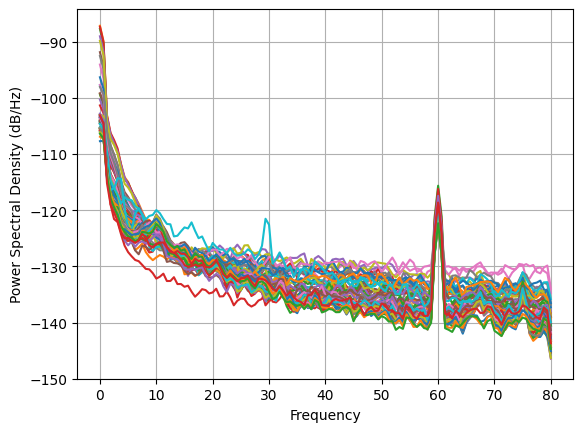

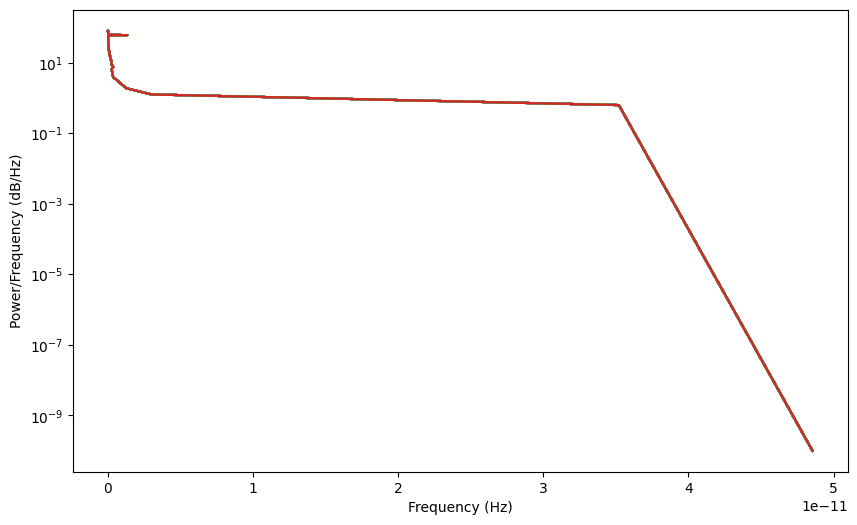

eyes closed


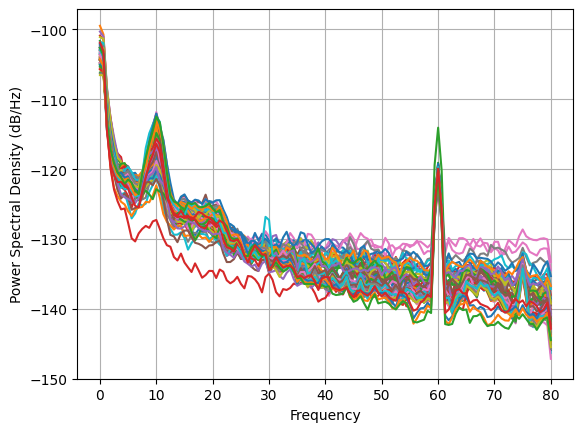

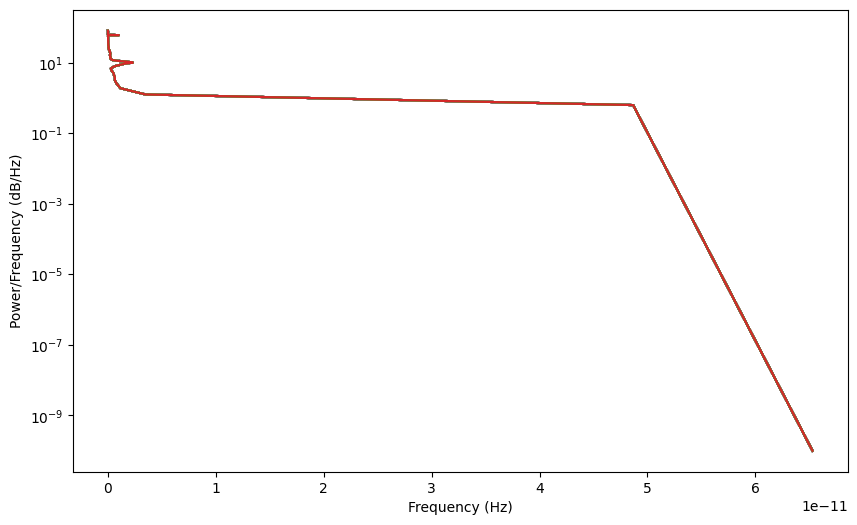

In [10]:
import mne
import numpy as np 
import matplotlib.pyplot as plt
import torch
import os
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from Data import download_EEGBCI

main_folder = './EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0'
subdirectories = [f.path for f in os.scandir(main_folder) if f.is_dir()]

opened_files = []
closed_files = []

i = 0
for subdirectory in subdirectories:
    files = os.listdir(subdirectory)
    
    if len(files) > 0 and i not in [13, 50, 68, 96, 108]: # 13, 50, 68, 96, 108 idx does not have 9760 seq len
        for file in files:
            
            if file[-6:] == '01.edf':
                # This is data for eyes opened
                eyes_opened = os.path.join(subdirectory, file)
                print(eyes_opened)
                opened_files.append(eyes_opened)

            if file[-6:] == '02.edf':
                # This is data for eyes closed
                eyes_closed = os.path.join(subdirectory, file)
                print(eyes_closed)
                closed_files.append(eyes_closed)
    else:
        print(f"No files found in {subdirectory}")
    
    i += 1
    
large_open_data = []    # This is a list of all the data for eyes opened
large_closed_data = []  # This is a list of all the data for eyes closed

for data in opened_files:
    value_open = mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False)
    if(len(value_open) == 64):
        large_open_data.append(value_open)

for data in closed_files:
    value_closed = mne.io.read_raw_edf(data, preload=True, verbose=False).get_data(verbose=False)
    if(len(value_closed) == 64):
        large_closed_data.append(value_closed)

print(large_open_data.__len__())   # This is the number of files for eyes opened
print(large_closed_data.__len__()) # This is the number of files for eyes closed



open_data = []
closed_data = []

for i in range(len(large_open_data)):
    if i not in [1,4,6,13,22,29,31,33,36,43,50,53,60,63,86,87,88,94,95,100,102]: # data that looks sussy
        open_data.append(large_open_data[i])

for i in range(len(large_closed_data)):
    if i not in [1,4,5,6,12,13,15,17,19,22,29,31,33,34.47,50,51,58,60,71,76,77,79,81,86,87,88,90,95,100]: # data that looks sussy
        closed_data.append(large_closed_data[i])   
        
training_data_open = np.array(open_data)
training_data_closed = np.array(closed_data)
print(np.shape(training_data_open))
print(np.shape(training_data_closed))



# Load the raw EEG data
edf_file = './EEGData/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf'
raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


def compute_psd(data, fs, nperseg=256, noverlap=None):
    """
    Compute Power Spectral Density (PSD) using the Welch method.

    Parameters:
        data (array): EEG data array with shape (n_channels, n_samples).
        fs (float): Sampling frequency.
        nperseg (int): Length of each segment for PSD estimation.
        noverlap (int): Number of overlapping samples between segments.
    
    Returns:
        freqs (array): Frequency values.
        psd (array): Power Spectral Density values.
    """
    n_channels, n_samples = data.shape
    psd = np.zeros((n_channels, nperseg // 2 + 1))

    for ch_idx in range(n_channels):
        f, Pxx = plt.psd(data[ch_idx], Fs=fs, NFFT=nperseg, noverlap=noverlap)
        # Add a small epsilon to avoid zero values
        psd[ch_idx] = Pxx + 1e-10

    return f, psd


# Get the EEG data using .get_data()
eeg_data = raw.get_data()
#eeg_data = large_closed_data[0]

# Set the sampling frequency
fs = raw.info['sfreq']

def average_across_arrays(generated_data):
    return generated_data.mean(dim=0)



## open data
averaged_data = average_across_arrays(torch.tensor(training_data_open).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(eeg_data.shape[0]):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

print("eyes open")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()



## closed data
averaged_data = average_across_arrays(torch.tensor(training_data_closed).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(eeg_data.shape[0]):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')

print("eyes closed")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()




NUM_CHANNELS = 64
SEQUENCE_LENGTH = 9760
LAMBDA_GP = 5

def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Gaussian normal distribution
def sample_normal_distribution(i, j, k):
    mu = 0
    sigma = 0.02
    return torch.Tensor(np.random.normal(mu, sigma, (i, j, k)))

def gradient_penalty(D, real, fake):
    alpha = torch.rand((BATCH_SIZE, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def plot_everything(generated_data, gen_err, critic_err):
    generated_data = generated_data.detach()
    
    # plotting generated data
    values = generated_data[0, 0, :]
    plt.plot(values.tolist())
    plt.show()

    # plotting PSD
    averaged_data = average_across_arrays(generated_data)
    freqs, psd = compute_psd(averaged_data, fs)
    plt.figure(figsize=(10, 6))  # Add this line to create a single figure
    for ch_idx in range(eeg_data.shape[0]):
        plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.show()

    # plotting G vs D losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(gen_err,label="Generator")
    plt.plot(critic_err,label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# zero grad optimizer after step()

Epoch 0: Critic error ([1.0944036854356023]) Generator err ([-0.008474503643810749])


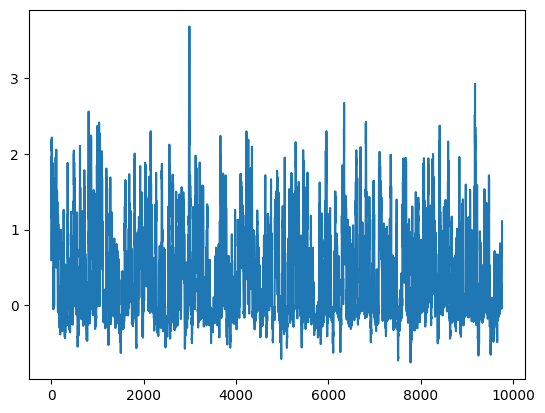

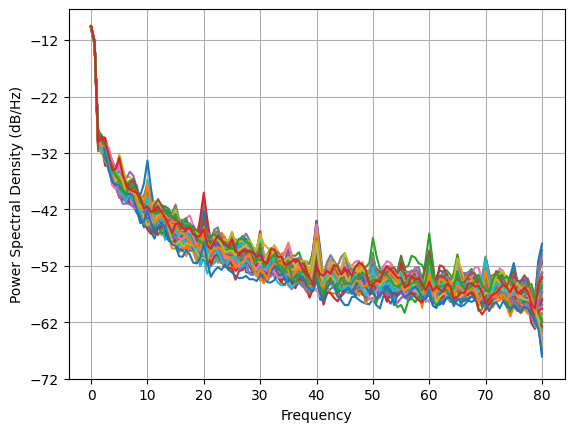

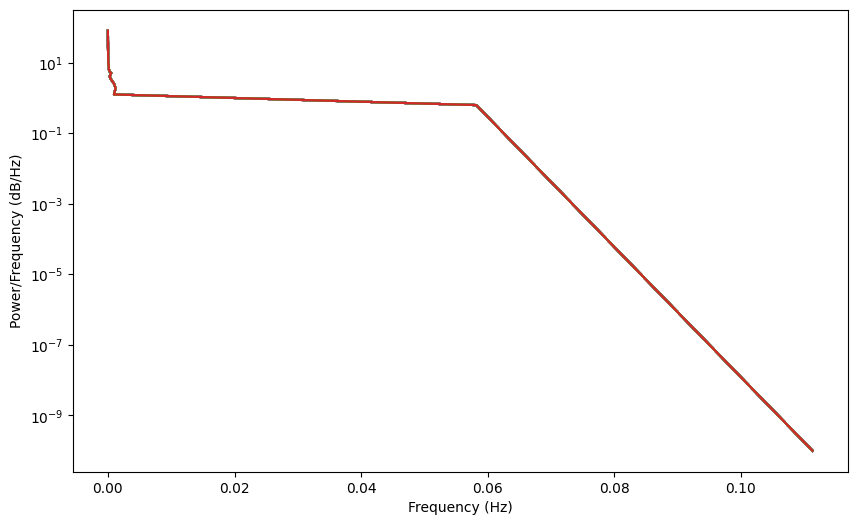

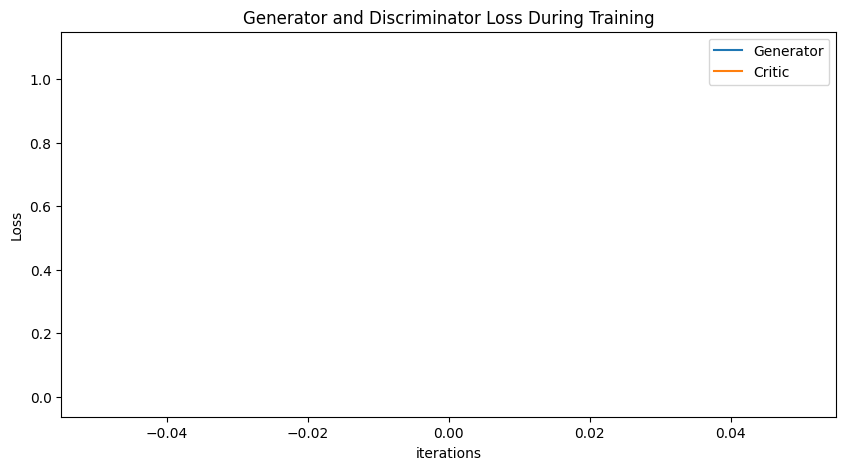

KeyboardInterrupt: 

In [11]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]
training_data = torch.tensor(training_data_open)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()
            critic_optimizer.zero_grad()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        G.zero_grad()
        loss_gen.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data, disc, gen = train()

torch.save(gen, 'genv3.pt')
torch.save(disc, 'discv3.pt')

plot_everything(generated_data, gen_err, critic_err)

# Zero grad weights before optimizer

Epoch 0: Critic error ([4.597072414349601]) Generator err ([-0.04533223807811737])


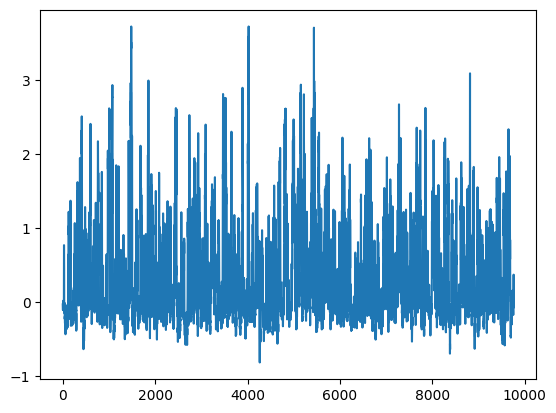

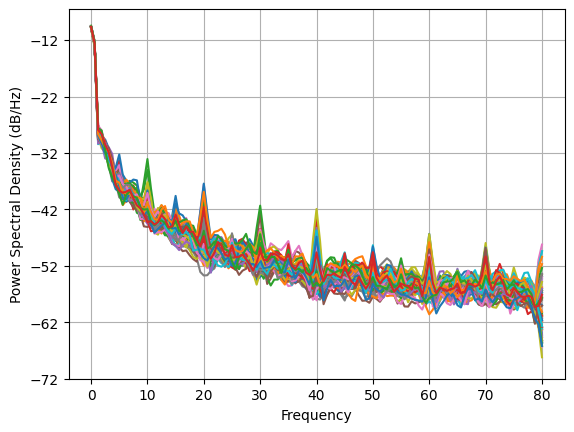

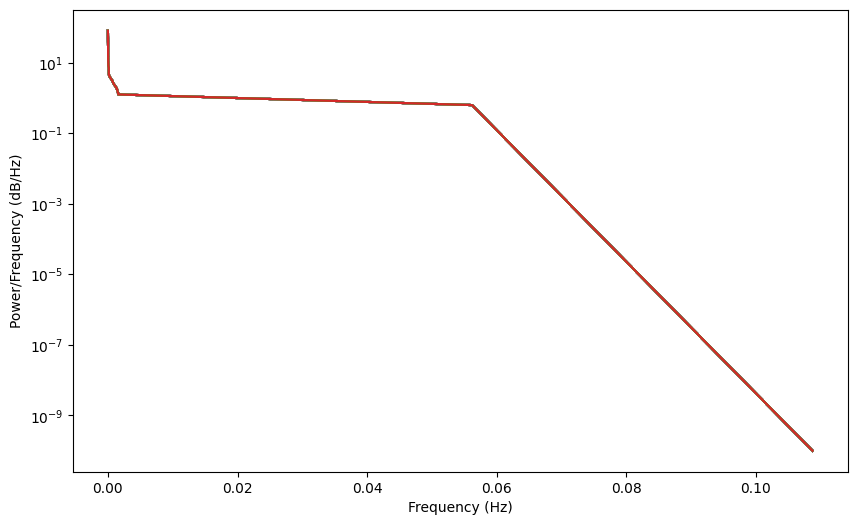

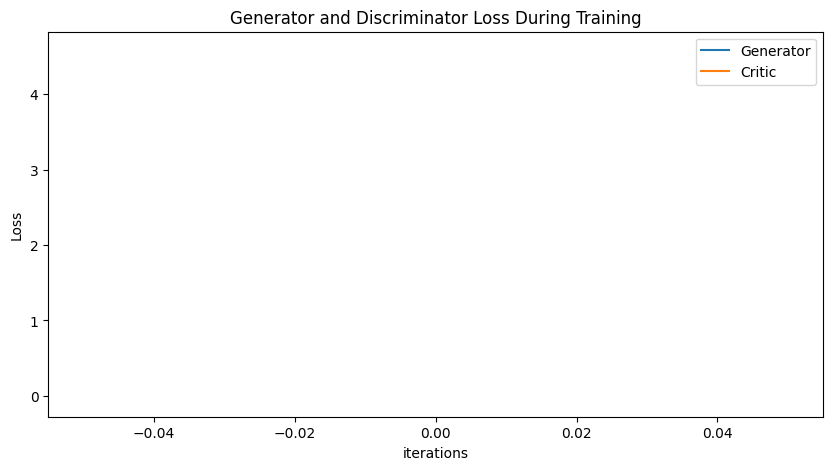

KeyboardInterrupt: 

In [12]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]
training_data = torch.tensor(training_data_open)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            D.zero_grad() # this is the change
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        G.zero_grad() # this is the change
        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_1, disc, gen = train()

torch.save(gen, 'genv3_1.pt')
torch.save(disc, 'discv3_1.pt')

plot_everything(generated_data_1, gen_err, critic_err)

# Zero grad after optimizer

Epoch 0: Critic error ([0.1918127316915066]) Generator err ([3.8881313800811768])


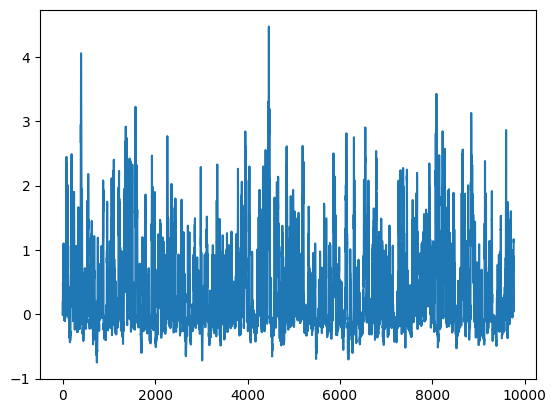

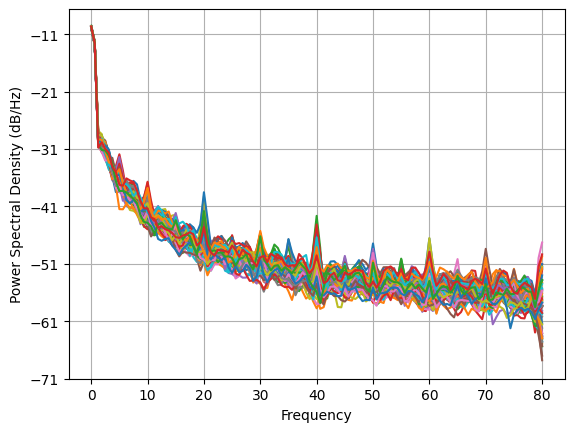

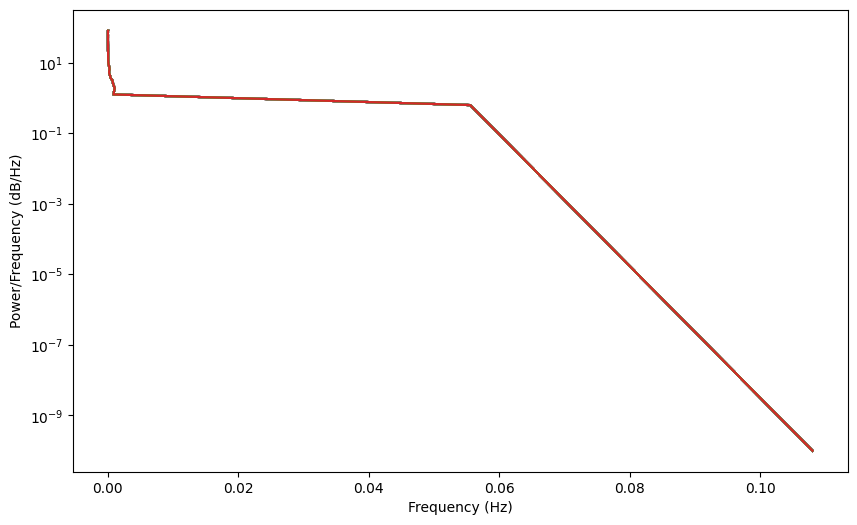

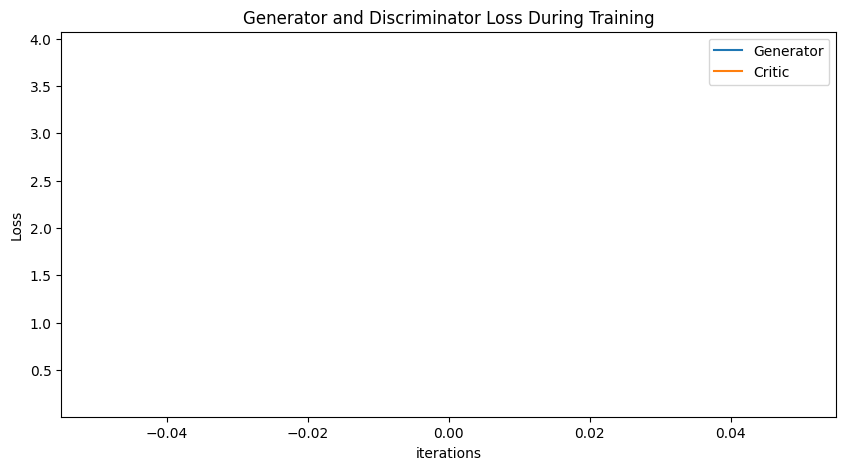

KeyboardInterrupt: 

In [13]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]
training_data = torch.tensor(training_data_open)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()
            critic_optimizer.zero_grad()

        generated_data = fake
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_2, disc, gen = train()

torch.save(gen, 'genv3_2.pt')
torch.save(disc, 'discv3_2.pt')

plot_everything(generated_data_2, gen_err, critic_err)

# Dataloader, Zero grad weights before, Zero grad after optimizer

Epoch 0: Critic error ([2.0262974965412397]) Generator err ([0.007028052117675543])


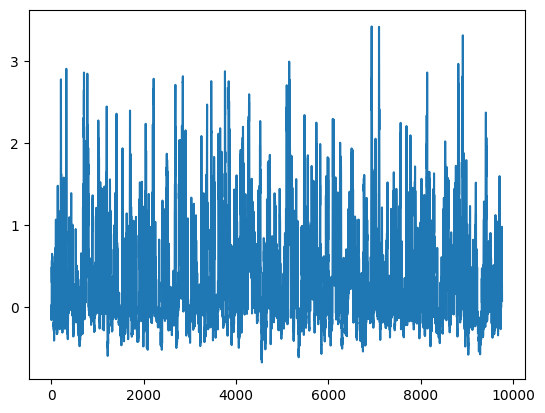

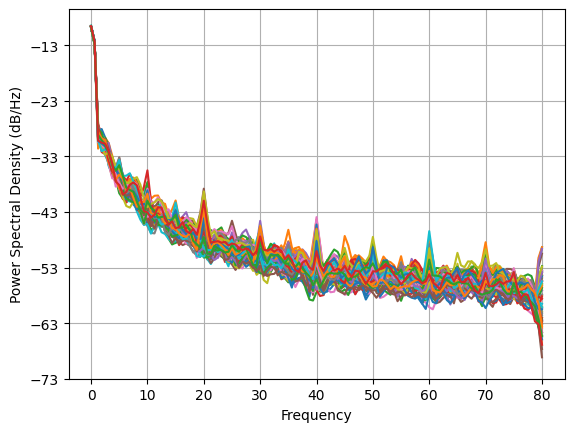

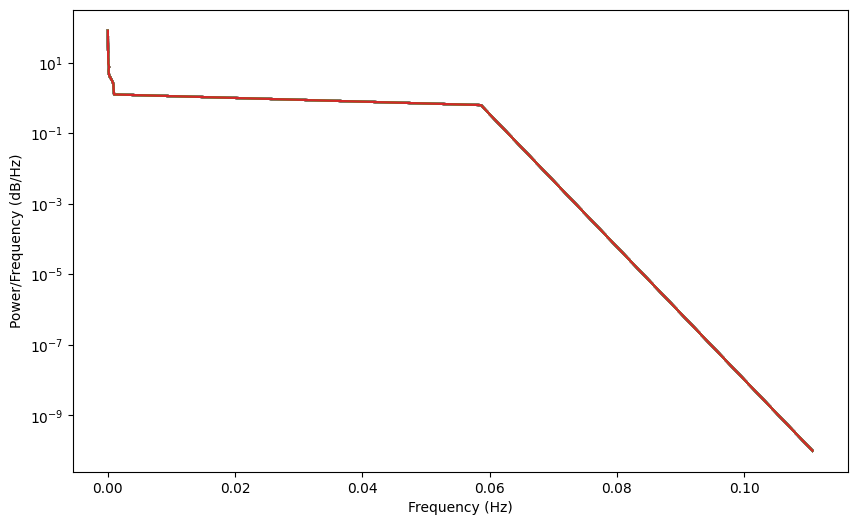

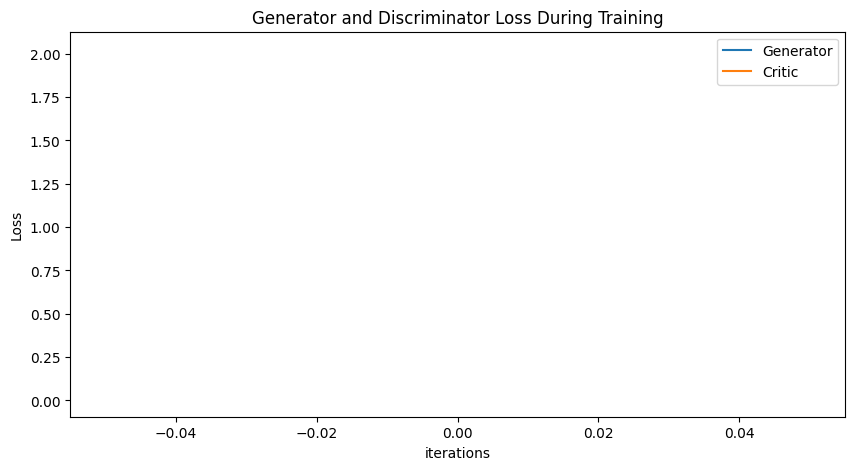

KeyboardInterrupt: 

In [25]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]

train_data = TensorDataset(torch.tensor(training_data_open).detach())
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            for real in train_loader:
                D.zero_grad()
                real = training_data.clone().detach()
                real.requires_grad=True
                noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
                fake = G(noise)
                critic_real = D(real).reshape(-1)
                critic_fake = D(fake).reshape(-1)
                gp = gradient_penalty(D, real, fake)
                critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
                critic_loss.backward(retain_graph=True)
                critic_optimizer.step()
                critic_optimizer.zero_grad()

        generated_data = fake
        G.zero_grad()
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()
        gen_optimizer.zero_grad()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_3, disc, gen = train()

torch.save(gen, 'genv3_3.pt')
torch.save(disc, 'discv3_3.pt')

plot_everything(generated_data_3, gen_err, critic_err)

# Dataloader, Zero grad after optimizer, follow gpt advice
# High hopes

Epoch 0: Critic error ([2.1684760297518983]) Generator err ([0.015101688914000988])


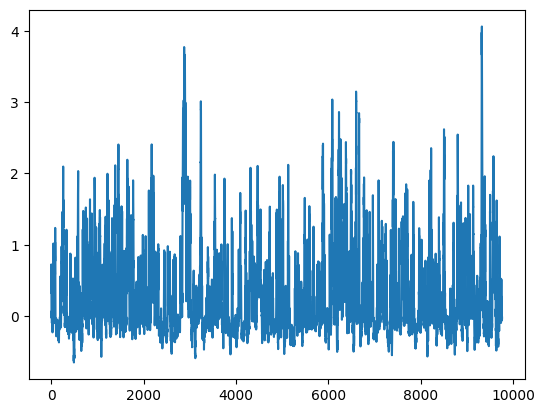

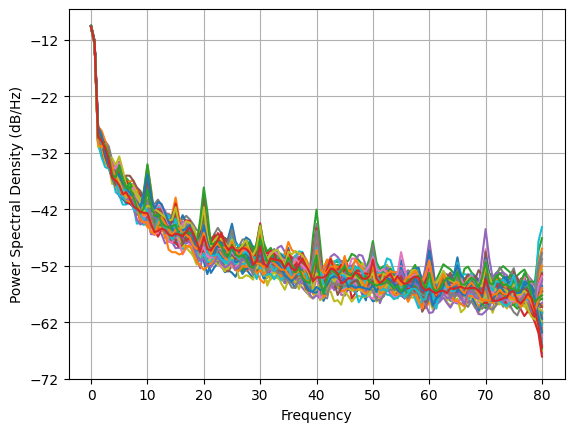

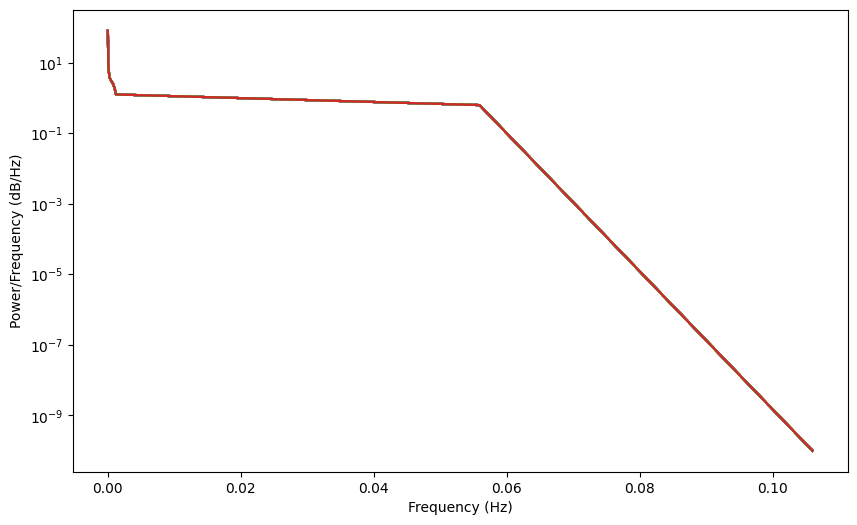

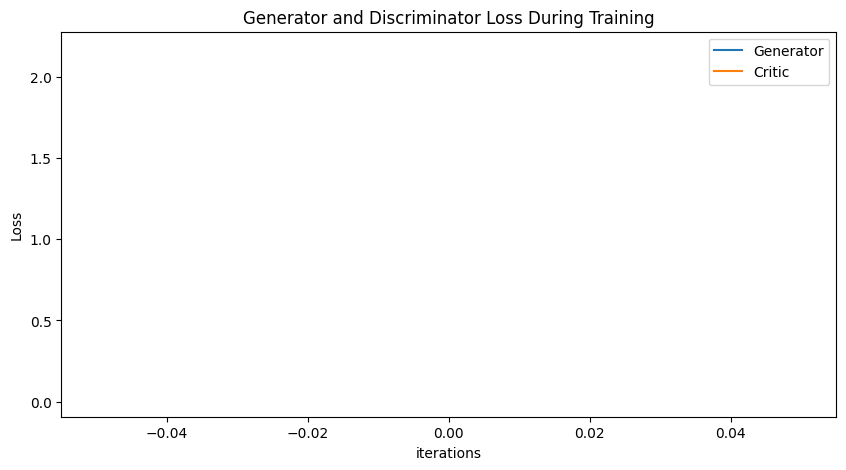

KeyboardInterrupt: 

In [34]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]

train_data = TensorDataset(torch.tensor(training_data_open).detach())
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for _ in range(5):
            for real in train_loader:
                D.zero_grad()
                real = training_data.clone().detach()
                real.requires_grad=True
                critic_real = D(real).reshape(-1)
                loss_critic_real = -torch.mean(critic_real)

                noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
                fake = G(noise)
                critic_fake = D(fake).reshape(-1)
                loss_critic_fake = torch.mean(critic_fake)
                gp = gradient_penalty(D, real, fake) * LAMBDA_GP
                loss_critic = loss_critic_real + loss_critic_fake + gp
                loss_critic.backward()
                critic_optimizer.step()            

        G.zero_grad()
        noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
        fake = G(noise)
        gen_fake = D(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        loss_gen.backward()
        gen_optimizer.step()
        
        generated_data = fake
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_4, disc, gen = train()

torch.save(gen, 'genv3_4.pt')
torch.save(disc, 'discv3_4.pt')

plot_everything(generated_data_4, gen_err, critic_err)

# replica above, Use batch of 10

torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([3, 64, 9760])
Epoch 0: Critic error ([1.4621923655963127]) Generator err ([0.057553909718990326])


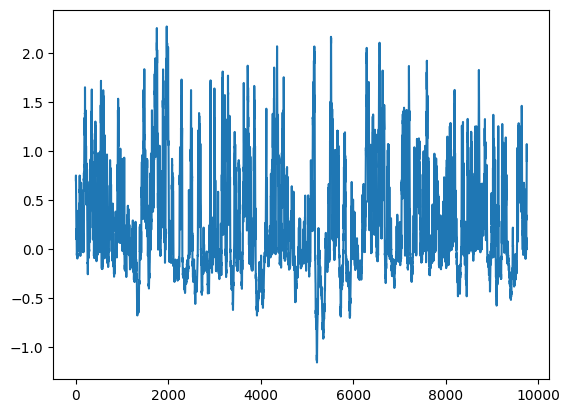

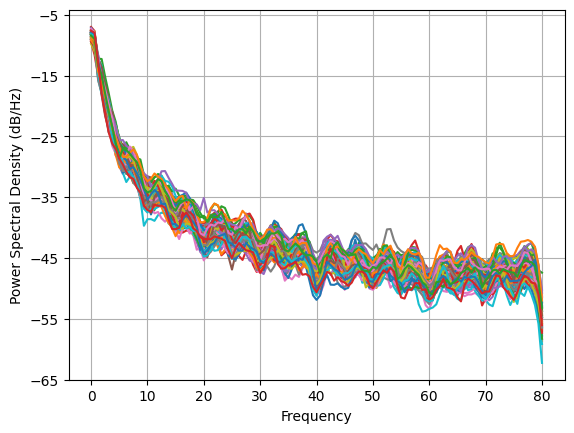

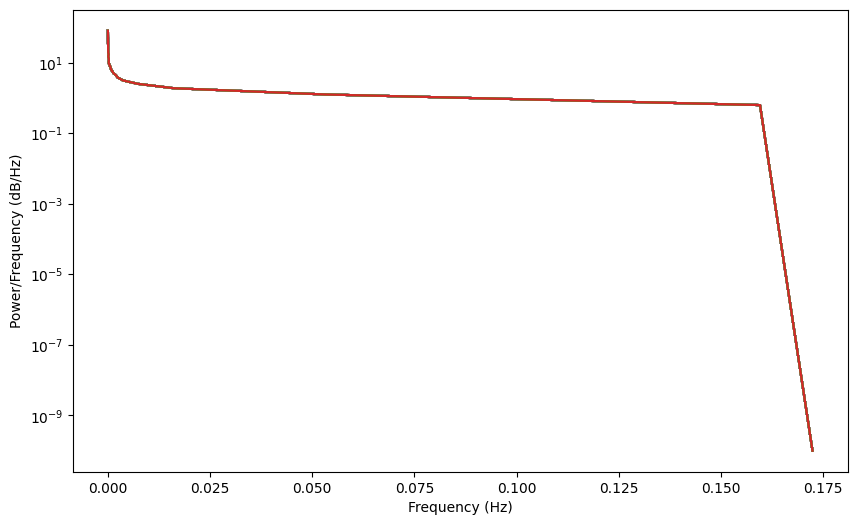

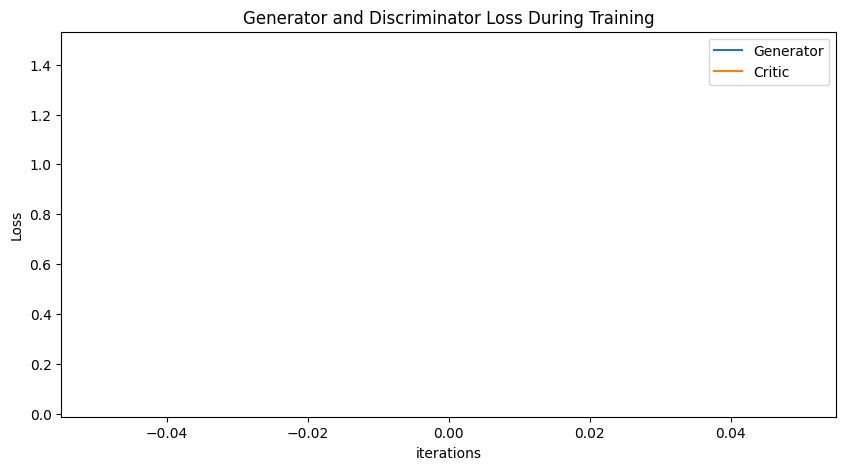

torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])
torch.Size([10, 64, 9760])


KeyboardInterrupt: 

In [33]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20

train_data = TensorDataset(torch.tensor(training_data_open).detach())
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def gradient_penalty_custom(D, real, fake, batch):
    alpha = torch.rand((batch, 1, 1)).repeat(1, NUM_CHANNELS, SEQUENCE_LENGTH)
    interpolated_seq = real * alpha + fake * (1 - alpha)

    # Calculate discriminator scores
    mixed_scores = D(interpolated_seq)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_seq,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for i, (real,) in enumerate(train_loader):
            D.zero_grad()
            real.requires_grad=True
            critic_real = D(real).reshape(-1)
            loss_critic_real = -torch.mean(critic_real)

            noise = sample_normal_distribution(real.size(0), 120, 305)
            fake = G(noise)
            critic_fake = D(fake).reshape(-1)
            loss_critic_fake = torch.mean(critic_fake)
            gp = gradient_penalty_custom(D, real, fake, real.size(0)) * LAMBDA_GP
            loss_critic = loss_critic_real + loss_critic_fake + gp
            loss_critic.backward()
            critic_optimizer.step()            

            if i % 4 == 0:
                G.zero_grad()
                noise = sample_normal_distribution(real.size(0), 120, 305)
                fake = G(noise)
                gen_fake = D(fake).reshape(-1)
                loss_gen = -torch.mean(gen_fake)
                loss_gen.backward()
                gen_optimizer.step()
        
        generated_data = fake
        critic_err.append(loss_critic.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_5, disc, gen = train()

torch.save(gen, 'genv3_5.pt')
torch.save(disc, 'discv3_5.pt')

plot_everything(generated_data_5, gen_err, critic_err)

# Use data loader

In [ ]:
NUM_EPOCHS = 100
PRINT_INTERVAL = 20
BATCH_SIZE = np.shape(training_data_open)[0]

train_data = TensorDataset(torch.tensor(training_data_open).detach())
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose1d(120, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.BatchNorm1d(64, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.block(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 64, kernel_size=9, stride=1, padding=4),
            nn.LeakyReLU(0.2),
            nn.Linear(305, 1)
        )

    def forward(self, x):
        x = x.float()
        x = self.block(x)
        return x

def train():
    critic_err, gen_err, generated_data = [], [], None
    G, D = Generator(), Discriminator()
    weights_init(G)
    weights_init(D)
    critic_optimizer = optim.RMSprop(D.parameters(), lr=2e-4)
    gen_optimizer = optim.RMSprop(G.parameters(), lr=2e-4)

    for epoch in range(NUM_EPOCHS):
        for i, real in enumerate(train_loader, 0):
            real = training_data.clone().detach()
            real.requires_grad=True
            noise = sample_normal_distribution(BATCH_SIZE, 120, 305)
            fake = G(noise)
            critic_real = D(real).reshape(-1)
            critic_fake = D(fake).reshape(-1)
            gp = gradient_penalty(D, real, fake)
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            D.zero_grad()
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

            generated_data = fake
            if i % 5 == 0:
                gen_fake = D(fake).reshape(-1)
                loss_gen = -torch.mean(gen_fake)
                G.zero_grad()
                loss_gen.backward()
                gen_optimizer.step()

        critic_err.append(critic_loss.item())
        gen_err.append(loss_gen.item())

        if epoch % PRINT_INTERVAL == 0:
            print("Epoch %s: Critic error (%s) Generator err (%s)" % (epoch, critic_err, gen_err))
            plot_everything(generated_data, critic_err, gen_err)

    return critic_err, gen_err, generated_data, D, G

critic_err, gen_err, generated_data_6, disc, gen = train()

torch.save(gen, 'genv3_6.pt')
torch.save(disc, 'discv3_6.pt')

plot_everything(generated_data_6, gen_err, critic_err)







# NORMALIZED






eyes open


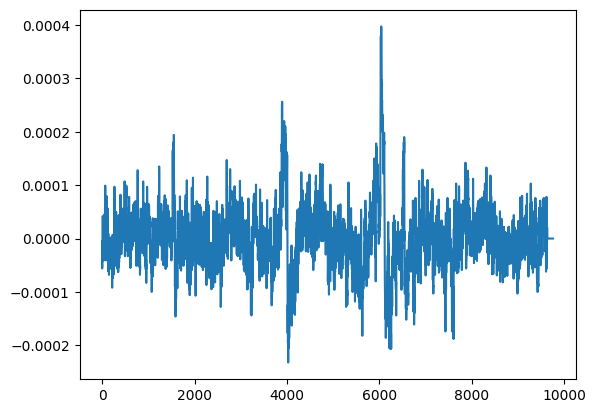

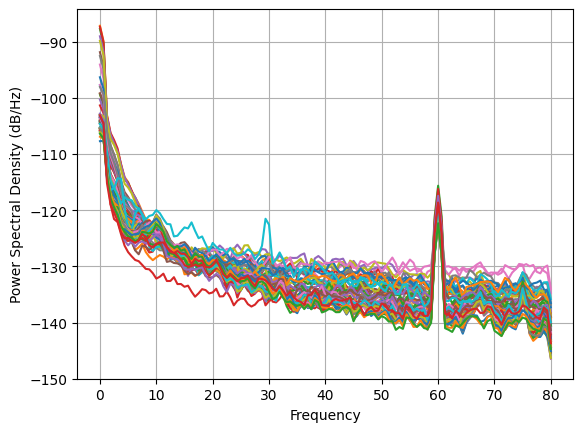

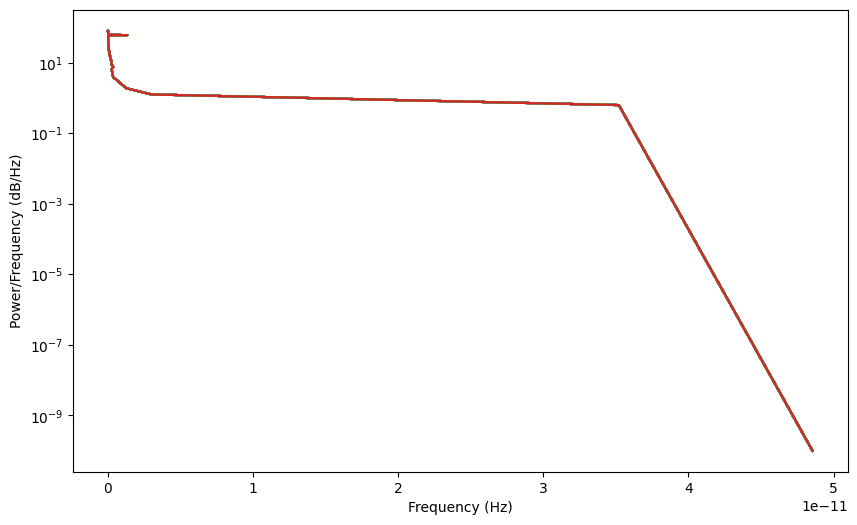

eyes open normalized


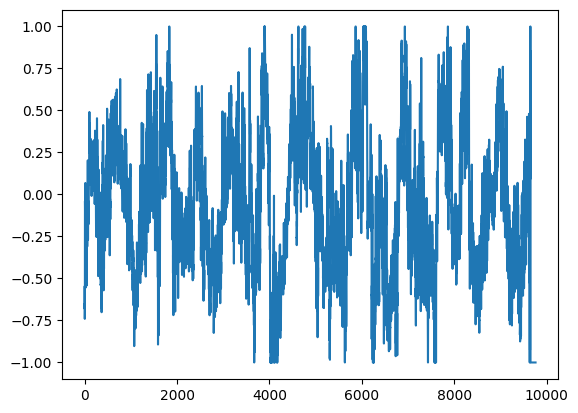

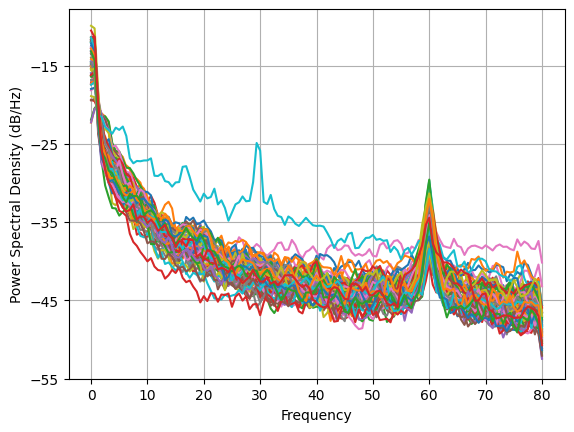

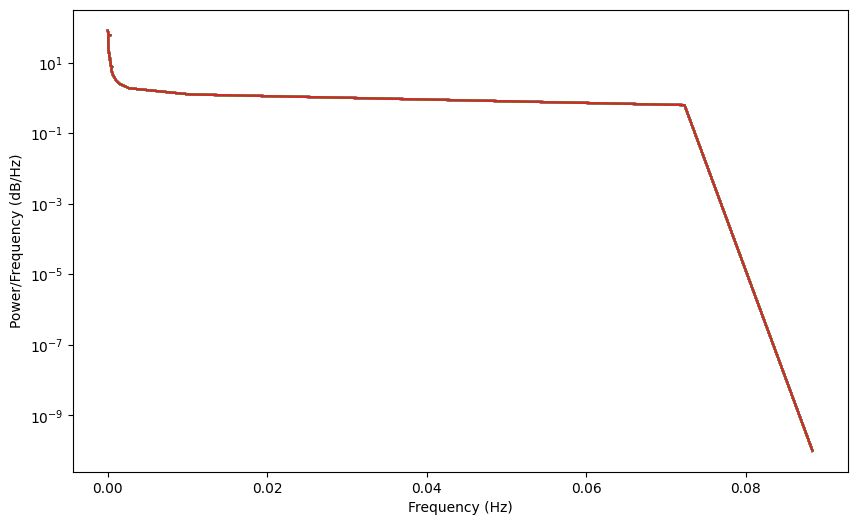

In [7]:
# Normalize the data (OPEN)
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_data_open = np.zeros_like(training_data_open)
for i in range(training_data_open.shape[1]):
    scaler = scaler.fit(training_data_open[:, i])
    normalized_data_open[:, i] = scaler.transform(training_data_open[:, i])

print("eyes open")
plt.plot(training_data_open[0][0])
plt.show()
averaged_data = average_across_arrays(torch.tensor(training_data_open).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(eeg_data.shape[0]):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()


print("eyes open normalized")
plt.plot(normalized_data_open[0][0])
plt.show()
averaged_data = average_across_arrays(torch.tensor(normalized_data_open).detach())
freqs, psd = compute_psd(averaged_data, fs)
plt.figure(figsize=(10, 6))  # Add this line to create a single figure
for ch_idx in range(eeg_data.shape[0]):
    plt.semilogy(freqs, psd[ch_idx], label=f'Channel {ch_idx + 1}')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.show()
